## Step 1: Import Libraries and Load the Data

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/Users/sandeepsrinivasdwaram/Desktop/BMIData.csv")

print(df.head())
print(df.info())
print(df.describe())

   SchoolYear NameHospital     Sex  EpiUnderweight  EpiHealthyWeight  \
0        2001      Borders  Female               2               334   
1        2001      Borders    Male               5               301   
2        2001      Lothian  Female              12               728   
3        2001      Lothian    Male              17               681   
4        2001         Fife  Female              17              1361   

   EpiOverweight  EpiObese  EpiOverweightAndObese  ValidCounts  UnvalidCounts  \
0             54        28                     82          418             82   
1             63        42                    105          411            105   
2            133       106                    239          979            239   
3            124       114                    238          936            238   
4            231       155                    386         1764            386   

   TotalCounts  
0          500  
1          516  
2         1218  
3         11

## Step 2: Data Cleaning

In [158]:
print(df.isnull().sum())
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

SchoolYear               0
NameHospital             0
Sex                      0
EpiUnderweight           0
EpiHealthyWeight         0
EpiOverweight            0
EpiObese                 0
EpiOverweightAndObese    0
ValidCounts              0
UnvalidCounts            0
TotalCounts              0
dtype: int64


In [159]:
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicate rows: 0


## Step 3: Create Proportional Variables

In [160]:
# Create new columns for proportions based on ValidCounts
df['PropUnderweight'] = df['EpiUnderweight'] / df['ValidCounts']
df['PropHealthyWeight'] = df['EpiHealthyWeight'] / df['ValidCounts']
df['PropOverweight'] = df['EpiOverweight'] / df['ValidCounts']
df['PropObese'] = df['EpiObese'] / df['ValidCounts']
df['PropOverweightAndObese'] = df['EpiOverweightAndObese'] / df['ValidCounts']
print(df[['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese', 'PropOverweightAndObese']].head())

   PropUnderweight  PropHealthyWeight  PropOverweight  PropObese  \
0         0.004785           0.799043        0.129187   0.066986   
1         0.012165           0.732360        0.153285   0.102190   
2         0.012257           0.743616        0.135853   0.108274   
3         0.018162           0.727564        0.132479   0.121795   
4         0.009637           0.771542        0.130952   0.087868   

   PropOverweightAndObese  
0                0.196172  
1                0.255474  
2                0.244127  
3                0.254274  
4                0.218821  


These new columns allow you to compare hospitals on a common scale, regardless of how many children they serve.

## Step 4: Exploratory Data Analysis (EDA) – Summary Statistics

In [161]:
print(df[['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese']].describe())

       PropUnderweight  PropHealthyWeight  PropOverweight   PropObese
count       516.000000         516.000000      516.000000  516.000000
mean          0.011183           0.757434        0.125710    0.105673
std           0.007941           0.031983        0.020968    0.021884
min           0.000000           0.583333        0.000000    0.046875
25%           0.005970           0.744919        0.114445    0.092561
50%           0.009811           0.761176        0.123808    0.101467
75%           0.014950           0.776438        0.135451    0.114766
max           0.050000           0.840708        0.244898    0.250000


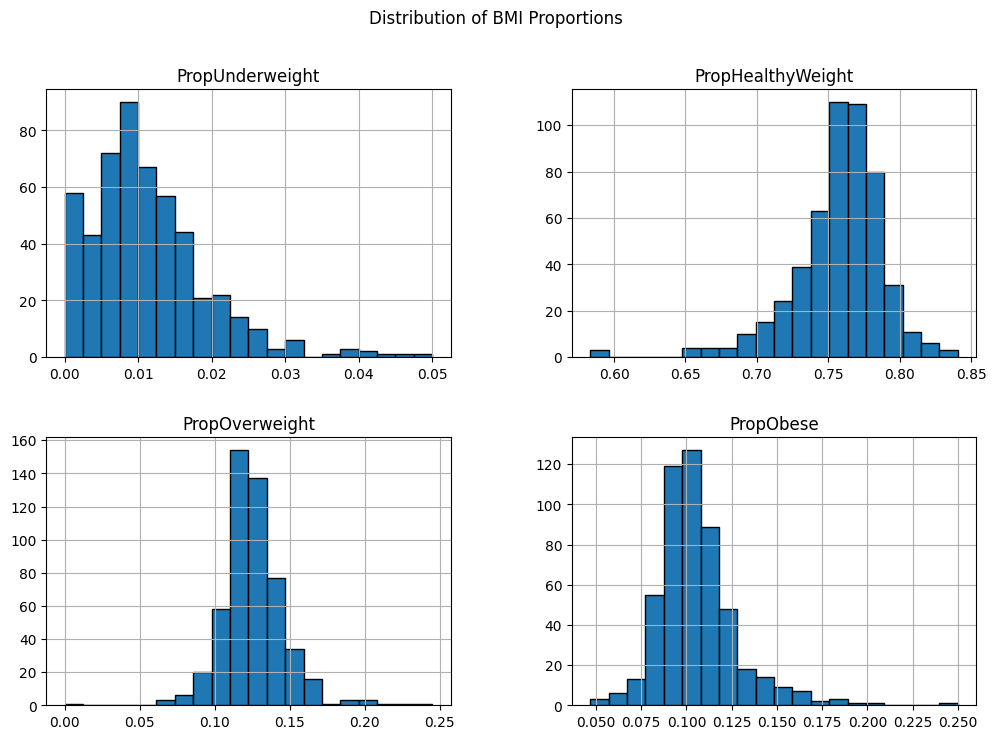

In [162]:
df[['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese']].hist(bins=20, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distribution of BMI Proportions")
plt.show()

This helps you see the average trends and differences in the BMI categories. The histo show that most kids (70–80%) are at a healthy weight across hospitals, while around 10% are overweight and another 10% are obese. Very few kids (0–2%) are underweight. This pattern highlights the issue of overweight and obesity, especially in hospitals where these numbers are much higher than usual.

## Step 5: Analyze Trends Over Time (SchoolYear)

In [163]:
yearly_trends = df.groupby('SchoolYear')[['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese']].mean().reset_index()
print(yearly_trends)

    SchoolYear  PropUnderweight  PropHealthyWeight  PropOverweight  PropObese
0         2001         0.014237           0.755882        0.130036   0.099844
1         2002         0.016210           0.748644        0.130714   0.104432
2         2003         0.012998           0.758594        0.130420   0.097988
3         2004         0.012765           0.742699        0.122960   0.121576
4         2005         0.012955           0.750621        0.130682   0.105742
5         2006         0.014303           0.764450        0.120995   0.100253
6         2007         0.016162           0.771667        0.118039   0.094132
7         2008         0.017211           0.773590        0.115641   0.093558
8         2009         0.013772           0.761248        0.121190   0.103790
9         2010         0.014889           0.761986        0.123864   0.099261
10        2011         0.010902           0.760933        0.125219   0.102946
11        2012         0.010541           0.769212        0.1198

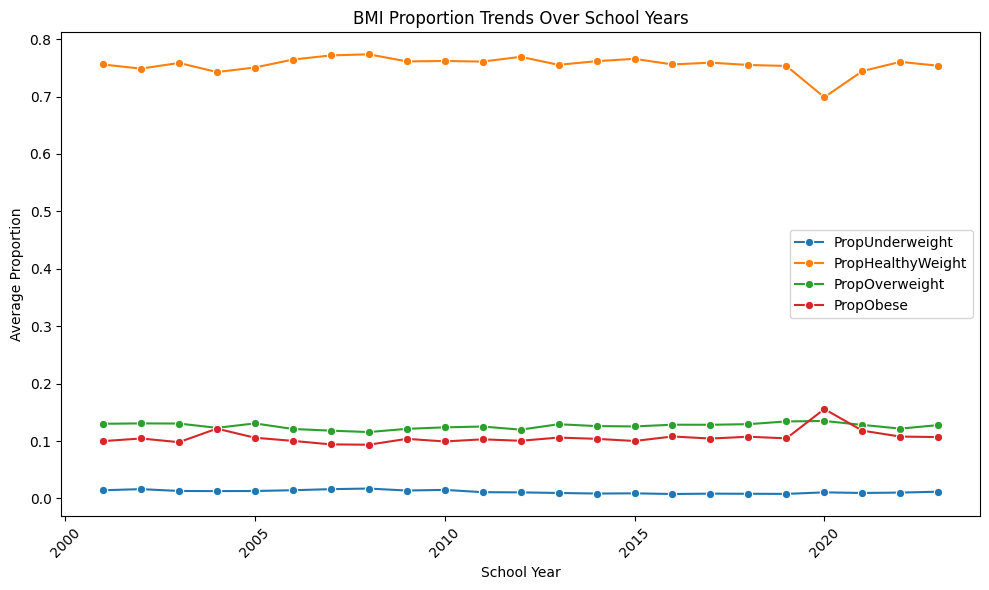

In [164]:
plt.figure(figsize=(10, 6))
for col in ['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese']:
    sns.lineplot(data=yearly_trends, x='SchoolYear', y=col, marker='o', label=col)
    
plt.xticks(rotation=45)
plt.title("BMI Proportion Trends Over School Years")
plt.xlabel("School Year")
plt.ylabel("Average Proportion")
plt.legend()
plt.tight_layout()
plt.show()

BMI categories proportions change over time.

## Step 6: Compare Hospitals

In [165]:
hospital_summary = df.groupby('NameHospital')[['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese']].mean().reset_index()
print(hospital_summary.head())

            NameHospital  PropUnderweight  PropHealthyWeight  PropOverweight  \
0     Ayrshire and Arran         0.013475           0.744227        0.128681   
1                Borders         0.008409           0.772596        0.125012   
2  Dumfries and Galloway         0.007731           0.742292        0.137032   
3                   Fife         0.009044           0.758541        0.127450   
4           Forth Valley         0.010546           0.776265        0.119511   

   PropObese  
0   0.113617  
1   0.093983  
2   0.112945  
3   0.104966  
4   0.093678  


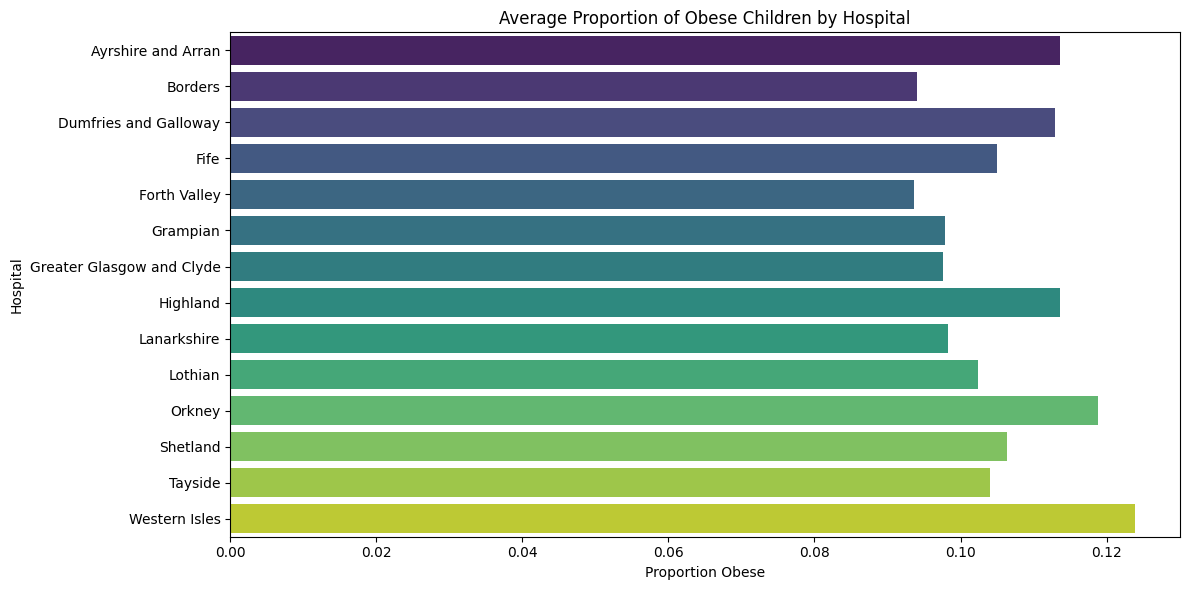

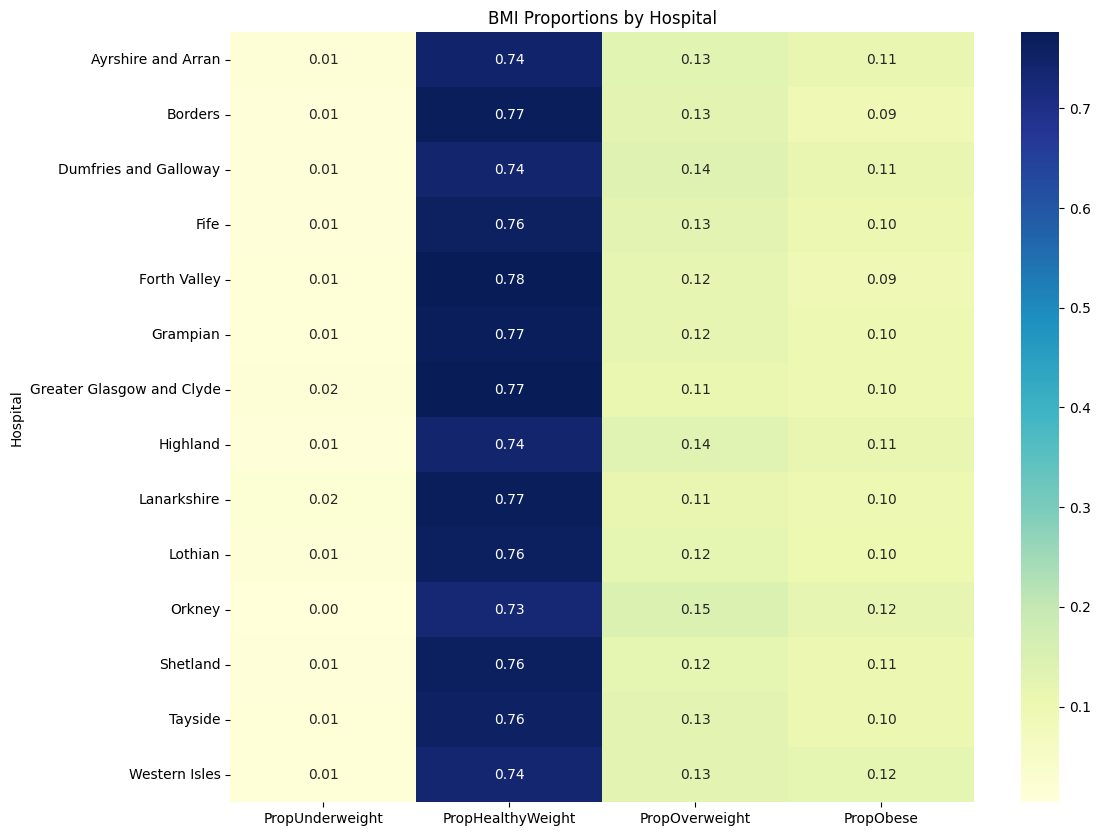

In [166]:
plt.figure(figsize=(12, 6))
sns.barplot(data=hospital_summary, x='PropObese', y='NameHospital', palette='viridis')
plt.title("Average Proportion of Obese Children by Hospital")
plt.xlabel("Proportion Obese")
plt.ylabel("Hospital")
plt.tight_layout()
plt.show()

hospital_heatmap = hospital_summary.set_index('NameHospital')
plt.figure(figsize=(12, 10))
sns.heatmap(hospital_heatmap, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("BMI Proportions by Hospital")
plt.ylabel("Hospital")
plt.show()

This compares how different hospitals perform in terms of BMI categories distributions.

## Step 7: Compare by Gender

In [167]:
gender_summary = df.groupby('Sex')[['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese']].mean().reset_index()
print(gender_summary)

      Sex  PropUnderweight  PropHealthyWeight  PropOverweight  PropObese
0  Female         0.008608           0.766216        0.124067   0.101109
1    Male         0.013758           0.748652        0.127353   0.110238


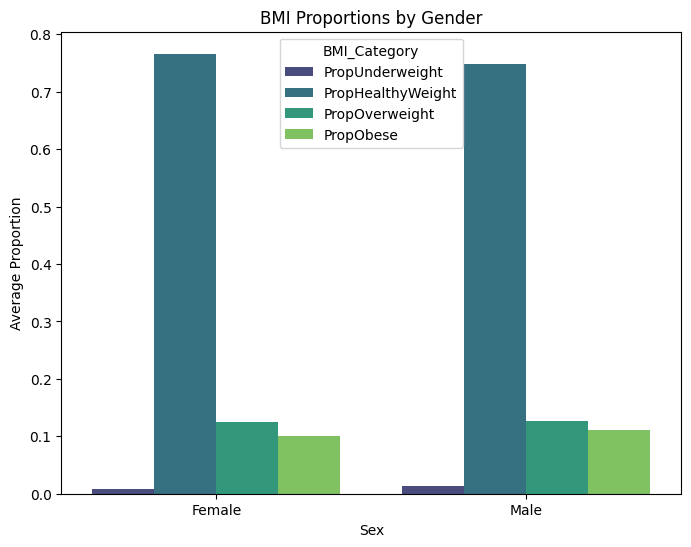

In [168]:
gender_summary_melted = gender_summary.melt(id_vars='Sex', var_name='BMI_Category', value_name='Average_Proportion')

plt.figure(figsize=(8, 6))
sns.barplot(data=gender_summary_melted, x='Sex', y='Average_Proportion', hue='BMI_Category', palette='viridis')
plt.title("BMI Proportions by Gender")
plt.ylabel("Average Proportion")
plt.show()

Highlights any gender-based differences in BMI categories distributions.

## Step 8: Create Pivot Tables for Quick Comparison

In [169]:
pivot = pd.pivot_table(
    df, 
    index='NameHospital', 
    columns='SchoolYear', 
    values=['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese'],
    aggfunc='mean'
)
print(pivot)

                          PropHealthyWeight                                \
SchoolYear                             2001      2002      2003      2004   
NameHospital                                                                
Ayrshire and Arran                      NaN       NaN       NaN       NaN   
Borders                            0.765702       NaN  0.762698  0.734882   
Dumfries and Galloway                   NaN       NaN       NaN  0.741763   
Fife                               0.754291  0.748538  0.749290  0.746864   
Forth Valley                            NaN       NaN       NaN       NaN   
Grampian                                NaN       NaN       NaN       NaN   
Greater Glasgow and Clyde               NaN       NaN       NaN       NaN   
Highland                                NaN       NaN       NaN       NaN   
Lanarkshire                        0.767947  0.764356  0.748501  0.761026   
Lothian                            0.735590  0.715051  0.763816  0.751594   

By creating matrix of our data we can reveal patterns across hospitals and years

## Clustering

## Step 1: Prepare the Data for Clustering

In [170]:
hospital_df = df.groupby('NameHospital').agg({
    'PropUnderweight': 'mean',
    'PropHealthyWeight': 'mean',
    'PropOverweight': 'mean',
    'PropObese': 'mean'
}).reset_index()
print(hospital_df.head())

            NameHospital  PropUnderweight  PropHealthyWeight  PropOverweight  \
0     Ayrshire and Arran         0.013475           0.744227        0.128681   
1                Borders         0.008409           0.772596        0.125012   
2  Dumfries and Galloway         0.007731           0.742292        0.137032   
3                   Fife         0.009044           0.758541        0.127450   
4           Forth Valley         0.010546           0.776265        0.119511   

   PropObese  
0   0.113617  
1   0.093983  
2   0.112945  
3   0.104966  
4   0.093678  


## Step 2: Standardize the Features

In [171]:
features = ['PropUnderweight', 'PropHealthyWeight', 'PropOverweight', 'PropObese']
X = hospital_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Step 3: Determine the Optimal Number of Clusters

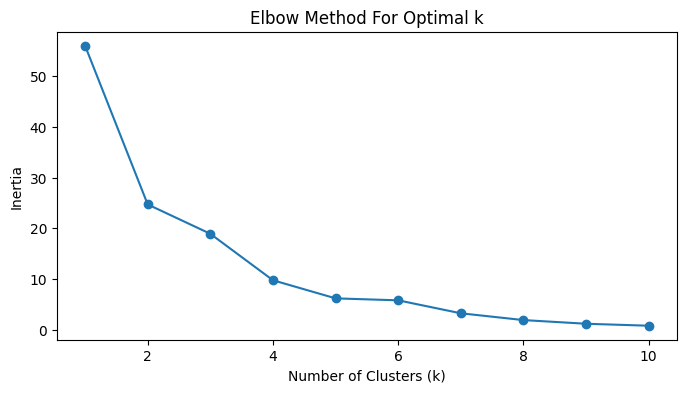

In [172]:
inertia = []
k_range = range(1, 11) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

## Step 4: Apply K-Means Clustering

In [173]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
hospital_df['Cluster'] = kmeans.fit_predict(X_scaled)
print(hospital_df.head())

            NameHospital  PropUnderweight  PropHealthyWeight  PropOverweight  \
0     Ayrshire and Arran         0.013475           0.744227        0.128681   
1                Borders         0.008409           0.772596        0.125012   
2  Dumfries and Galloway         0.007731           0.742292        0.137032   
3                   Fife         0.009044           0.758541        0.127450   
4           Forth Valley         0.010546           0.776265        0.119511   

   PropObese  Cluster  
0   0.113617        1  
1   0.093983        0  
2   0.112945        2  
3   0.104966        0  
4   0.093678        0  


## Step 5: Analyze and Visualize the Clusters

## a. View Cluster Centers (in the standardized space)

In [174]:
print("Cluster Centers (Standardized):")
print(kmeans.cluster_centers_)
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_original, columns=features)
print("Cluster Centers (Original Scale):")
print(centers_df)

Cluster Centers (Standardized):
[[ 0.27277218  0.67064432 -0.53733425 -0.65457816]
 [ 0.46421339 -1.06955053  0.10206212  1.41651882]
 [-1.12779213 -1.29889926  1.54396135  1.0193886 ]]
Cluster Centers (Original Scale):
   PropUnderweight  PropHealthyWeight  PropOverweight  PropObese
0         0.011966           0.766883        0.121255   0.099896
1         0.012719           0.741425        0.127122   0.118733
2         0.006457           0.738070        0.140352   0.115121


## b. Visualize Clusters Using PCA

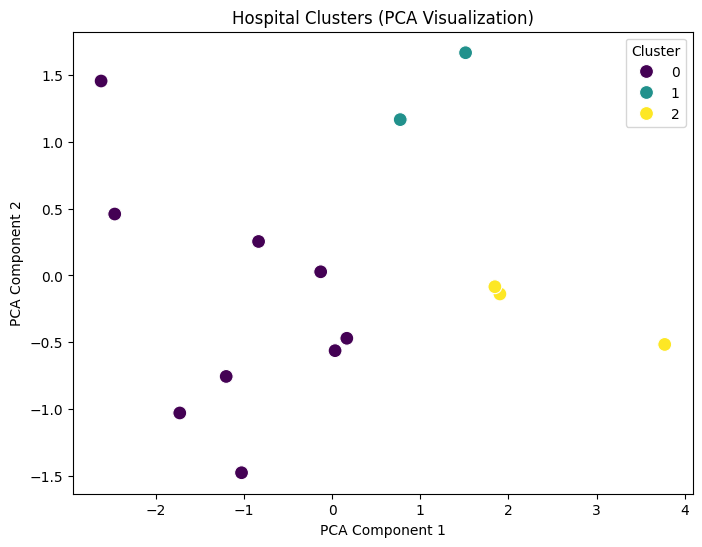

In [175]:
# Reduce dimensions to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Add PCA components to the hospital dataframe
hospital_df['PCA1'] = X_pca[:, 0]
hospital_df['PCA2'] = X_pca[:, 1]
# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=hospital_df, palette='viridis', s=100)
plt.title('Hospital Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## c. Examine Cluster Profiles

In [176]:
cluster_summary = hospital_df.groupby('Cluster')[features].mean().reset_index()
print(cluster_summary)

   Cluster  PropUnderweight  PropHealthyWeight  PropOverweight  PropObese
0        0         0.011966           0.766883        0.121255   0.099896
1        1         0.012719           0.741425        0.127122   0.118733
2        2         0.006457           0.738070        0.140352   0.115121


## Linear Regression on Proportions

## Step 1: Create the Outcome Variable (Proportion)

In [177]:
print(df[['EpiObese', 'ValidCounts', 'PropObese']].head())

   EpiObese  ValidCounts  PropObese
0        28          418   0.066986
1        42          411   0.102190
2       106          979   0.108274
3       114          936   0.121795
4       155         1764   0.087868


## Step 2: Prepare Predictor Variables


In [178]:
df['SchoolYear'] = df['SchoolYear'].astype('category')
df['Sex'] = df['Sex'].astype('category')

## Step 3: Fit a Linear Regression Model

In [179]:
formula = "PropObese ~ C(SchoolYear) + C(Sex)"
model_linear = smf.ols(formula=formula, data=df).fit()
print(model_linear.summary())

                            OLS Regression Results                            
Dep. Variable:              PropObese   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     7.667
Date:                Wed, 05 Feb 2025   Prob (F-statistic):           2.43e-21
Time:                        11:06:52   Log-Likelihood:                 1319.5
No. Observations:                 516   AIC:                            -2591.
Df Residuals:                     492   BIC:                            -2489.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.09

A key finding is that obesity rates went up a lot in 2020 (5.59% higher than usual), with smaller but noticeable increases in 2004 and 2021. Additionally, males tend to have higher obesity rates than females (0.91% more). This suggests that certain years (especially 2020) and gender differences are important in understanding obesity trends.

## Binomial (Logistic) Regression on Aggregated Counts

In [180]:
df['NonObese'] = df['ValidCounts'] - df['EpiObese']
print(df[['ValidCounts', 'EpiObese', 'NonObese']].head())

   ValidCounts  EpiObese  NonObese
0          418        28       390
1          411        42       369
2          979       106       873
3          936       114       822
4         1764       155      1609


## Step 1: Fit a Binomial Regression Model

In [181]:
model_binom = smf.glm(
    formula="EpiObese ~ C(SchoolYear) + C(Sex)", 
    data=df,
    family=sm.families.Binomial(),
    weights=df['ValidCounts']  
).fit()
print(model_binom.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               EpiObese   No. Observations:                  516
Model:                            GLM   Df Residuals:                      492
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Wed, 05 Feb 2025   Deviance:                   7.4942e+06
Time:                        11:06:52   Pearson chi2:                 1.22e+23
No. Iterations:                     2   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              9.667e+

## Diagnostic Checking

## Step 1: Residuals vs. Fitted Values Plot

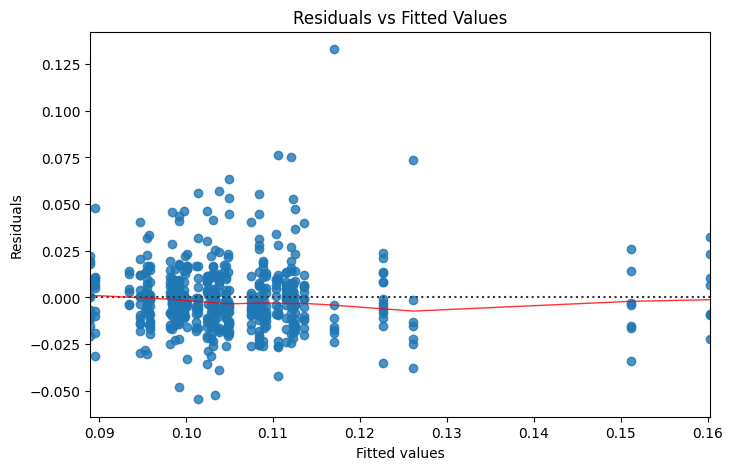

In [182]:
fitted_vals = model_linear.fittedvalues
residuals = model_linear.resid
plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

## Step 2: Q-Q Plot of Residuals

<Figure size 600x500 with 0 Axes>

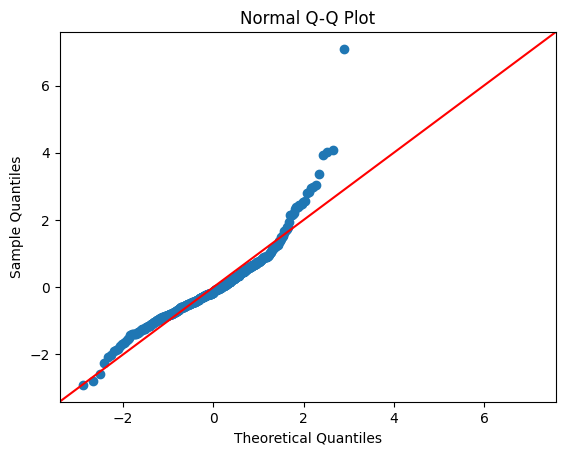

In [183]:
plt.figure(figsize=(6, 5))
sm.qqplot(residuals, line='45', fit=True)
plt.title('Normal Q-Q Plot')
plt.show()

Residuals lie along the 45-degree line, they are approximately normally distributed. Deviations might indicate skewness or heavy tails.

## Step 3: Spread-Location Plot

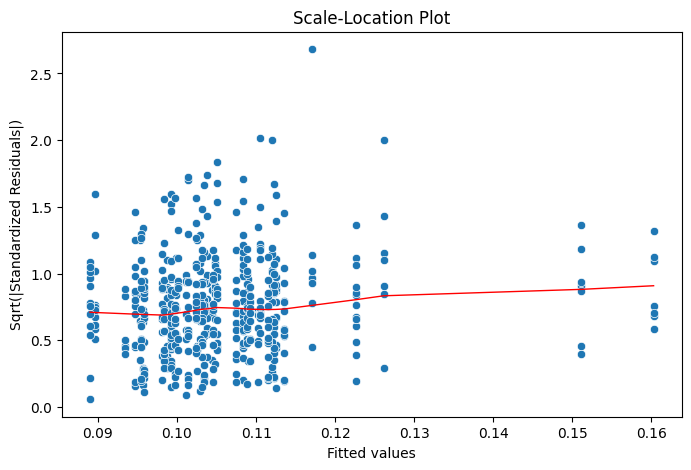

In [184]:
influence = model_linear.get_influence()
standardized_residuals = influence.resid_studentized_internal
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=np.sqrt(np.abs(standardized_residuals)))
sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(standardized_residuals)),
            scatter=False, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Sqrt(|Standardized Residuals|)')
plt.title('Scale-Location Plot')
plt.show()

A horizontal line suggests constant variance. An upward or downward trend indicates non-constant variance (heteroscedasticity)

## Step 4: Residuals vs. Leverage Plot

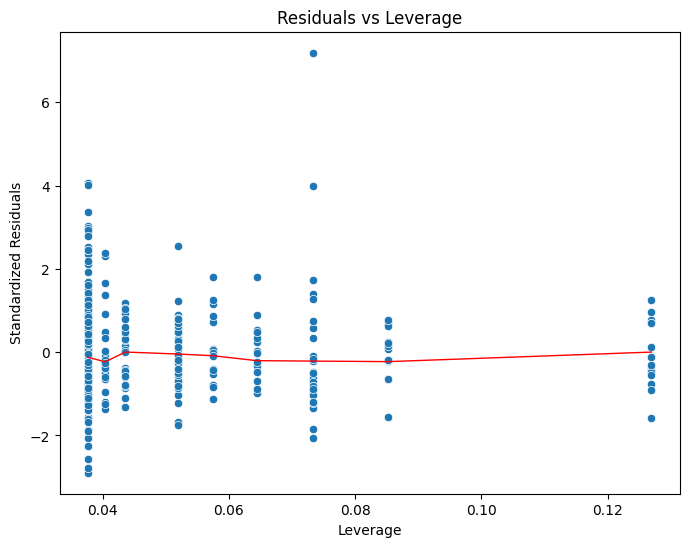

In [185]:
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=leverage, y=standardized_residuals)
sns.regplot(x=leverage, y=standardized_residuals, scatter=False, lowess=True, 
            line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Leverage')
plt.show()

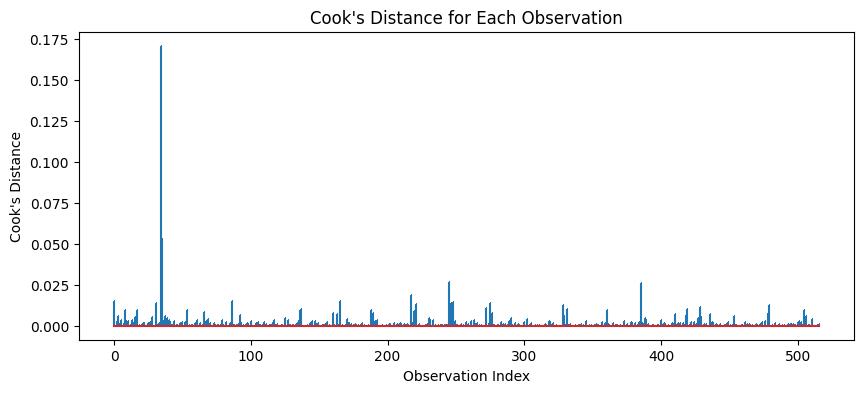

In [186]:
plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Observation")
plt.show()

Points with high leverage and large standardized residuals (or high Cook’s distance) may be influential and warrant further investigation.

## Final Takeaways

### Overall BMI Distribution: <br>

Most children (about 70–80%) are at a healthy weight, while around 10% are overweight and another 10% are obese. Very few children (less than 2%) are underweight. This shows that while the majority of kids have a healthy BMI, a significant number are overweight or obese, which is a concern.

### Hospital Comparisons:<br>
When hospitals were grouped based on the proportion of BMI data (to avoid bias from hospital size), they didn’t form very different clusters. This means most hospitals have similar BMI patterns. However, a few hospitals showed higher rates of overweight or obesity compared to others, which might need more attention or specific actions to address the issue.

### Time Trends & Gender Differences: <br>

Linear regression shows that obesity rates noticeably increased in 2020, with men consistently having slightly higher rates than women.
While some years and gender differences stand out, the model’s moderate R-squared (~26%) suggests that other factors, like income levels and eating habits, likely play a role in obesity trends.

### Actionable Insights:<br>

Target interventions at specific years or hospitals with higher obesity rates. Look into the reasons behind the sharp increase in 2020, such as potential policy changes or wider societal factors. Consider adding more data (like information on nutrition programs or physical education availability) or using different analysis methods (like mixed-effects or Poisson/Negative Binomial models) to gain a clearer and more accurate picture of these trends.

**Overall,** the analysis shows key trends most children have a healthy weight, but a significant number face overweight or obesity, especially in certain years and among boys. These insights can help shape better public health strategies and allocate resources more effectively.